In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, 
                  template='none')
    fig.show()

The data used for this model is stock price data for bitcoin. The can be found on Kaggle at the follow address:
https://www.kaggle.com/mczielinski/bitcoin-historical-data/code

In [3]:
path = 'data/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
data = pd.read_csv(path)

In [4]:
df = data.copy()

In [5]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [6]:
df= df.drop(columns=['Open','High','Low','Volume_(BTC)','Volume_(Currency)','Weighted_Price'])
df = df.reset_index()

In [7]:
df = df.interpolate()

In [8]:
df.isna().sum()

Timestamp    0
Close        0
dtype: int64

In [9]:
df.columns = ['Date','Observed']

In [19]:
df = df[df.Date>'2014-12-31']

In [20]:
ilinechart(df, x='Date', y='Observed')

In [21]:
import statsmodels.api as sm

adf_test = sm.tsa.stattools.adfuller(df['Observed'])

results = pd.Series(adf_test[0:4], 
                    index=['ADF Test Statistic','P-Value',
                           '# Lags Used','# Observations Used'])

for key, value in adf_test[4].items():
    results['Critical Value (%s)'%key] = value

print('Augmented Dickey-Fuller Test Results:\n')
print(results)

Augmented Dickey-Fuller Test Results:

ADF Test Statistic         1.281945
P-Value                    0.996506
# Lags Used               26.000000
# Observations Used     2165.000000
Critical Value (1%)       -3.433374
Critical Value (5%)       -2.862876
Critical Value (10%)      -2.567481
dtype: float64


In [22]:
# H_0: Time series is not stationary
# H_a: Time series is stationary
def check_sig(results):
  if results['P-Value'] < 0.05:
    print('P-Value: ', results['P-Value'])
    print('Reject null hypothesis')
    print('Data is stationary')
  else:
    print('P-Value: ', results['P-Value'])
    print('Fail to reject null hypothesis')
    print('Data is not stationary')

In [23]:
check_sig(results)

P-Value:  0.9965059090743679
Fail to reject null hypothesis
Data is not stationary


In [24]:
df['Diff_1'] = df.Observed.diff()

In [25]:
ilinechart(df, 'Date', 'Diff_1')

In [26]:
adf_test = sm.tsa.stattools.adfuller(df['Diff_1'][1:])

results = pd.Series(adf_test[0:4], 
                    index=['ADF Test Statistic','P-Value',
                           '# Lags Used','# Observations Used'])

for key, value in adf_test[4].items():
    results['Critical Value (%s)'%key] = value

print('Augmented Dickey-Fuller Test Results:\n')
print(results)

Augmented Dickey-Fuller Test Results:

ADF Test Statistic     -6.437656e+00
P-Value                 1.637590e-08
# Lags Used             2.500000e+01
# Observations Used     2.165000e+03
Critical Value (1%)    -3.433374e+00
Critical Value (5%)    -2.862876e+00
Critical Value (10%)   -2.567481e+00
dtype: float64


In [27]:
check_sig(results)

P-Value:  1.6375902189114388e-08
Reject null hypothesis
Data is stationary


In [28]:
n_lags = 28
lags = np.arange(1, n_lags+1)

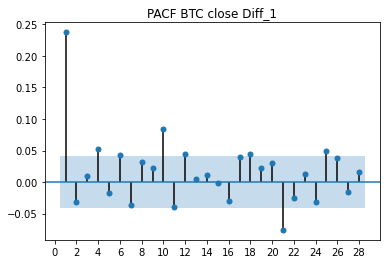

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.Diff_1[1:], lags=lags, title = 'PACF BTC close Diff_1')
plt.xticks(np.arange(0, n_lags+1,2))
plt.show()

Differences contains at least one Autocorrelated value.

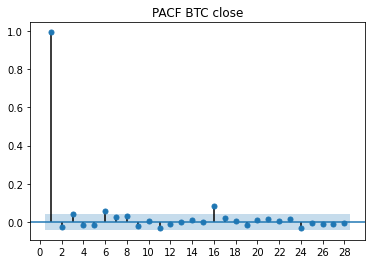

In [31]:
plot_pacf(df.Observed, lags=lags, title = 'PACF BTC close')
plt.xticks(np.arange(0, n_lags+1,2))
plt.show()

The data itself has at least one autocorrelated value.

In [32]:
from statsmodels.tsa.arima_model import ARIMA

In [34]:
model = ARIMA(df.Observed, order=(1,1,0)).fit()
df['ARIMA_110'] = model.predict(typ='levels')
print(model.summary())
print('Residuals Description')
print(model.resid.describe())

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:             D.Observed   No. Observations:                 2191
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -15188.454
Method:                       css-mle   S.D. of innovations            247.956
Date:                Mon, 15 Feb 2021   AIC                          30382.907
Time:                        19:23:12   BIC                          30399.984
Sample:                             1   HQIC                         30389.149
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.1770      6.955      1.895      0.058      -0.454      26.808
ar.L1.D.Observed     0.2384      0.021     11.468      0.000       0.198       0.279
                            

In [35]:
df.columns

Index(['Date', 'Observed', 'Diff_1', 'ARIMA_110'], dtype='object')

In [36]:
df = df.drop(columns=['Diff_1'])

In [38]:
melted = pd.melt(df, id_vars = 'Date', value_vars = ['Observed', 'ARIMA_110'])

ilinechart(melted, 'Date', 'value', groups='variable', title='Observed vs Modeled')

In [40]:
model = ARIMA(df.Observed, order=(1,1,1)).fit()
df['ARIMA_111'] = model.predict(typ='levels')
print(model.summary())
print('Residuals Description')
print(model.resid.describe())

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:             D.Observed   No. Observations:                 2191
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15187.506
Method:                       css-mle   S.D. of innovations            247.848
Date:                Mon, 15 Feb 2021   AIC                          30383.011
Time:                        19:28:52   BIC                          30405.780
Sample:                             1   HQIC                         30391.333
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.1322      6.779      1.937      0.053      -0.154      26.418
ar.L1.D.Observed     0.1255      0.084      1.497      0.134      -0.039       0.290
ma.L1.D.Observed     0.1197 

In [41]:
melted = pd.melt(df, id_vars = 'Date', value_vars = ['Observed', 'ARIMA_110','ARIMA_111'])

ilinechart(melted, 'Date', 'value', groups='variable', title='Observed vs Modeled')

In [47]:
df.columns

Index(['Date', 'Observed', 'ARIMA_110', 'ARIMA_111', 'ARIMA_001', 'ARIMA_100',
       'ARIMA_010'],
      dtype='object')

In [43]:
model = ARIMA(df.Observed, order=(0,0,1)).fit()
df['ARIMA_001'] = model.predict(typ = 'levels')
print(model.summary())
print('Residuals Description')
print(model.resid.describe())

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:               Observed   No. Observations:                 2192
Model:                     ARMA(0, 1)   Log Likelihood              -20259.374
Method:                       css-mle   S.D. of innovations           2497.122
Date:                Mon, 15 Feb 2021   AIC                          40524.748
Time:                        19:37:50   BIC                          40541.826
Sample:                             0   HQIC                         40530.989
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5126.6113    104.532     49.043      0.000    4921.732    5331.491
ma.L1.Observed     0.9603      0.004    233.206      0.000       0.952       0.968
                                    

In [46]:
model = ARIMA(df.Observed, order=(0,1,0)).fit()
df['ARIMA_010'] = model.predict(typ='levels')
print(model.summary())
print('Residuals Description')
print(model.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:             D.Observed   No. Observations:                 2191
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -15252.313
Method:                           css   S.D. of innovations            255.292
Date:                Mon, 15 Feb 2021   AIC                          30508.626
Time:                        19:40:05   BIC                          30520.011
Sample:                             1   HQIC                         30512.787
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0590      5.454      2.394      0.017       2.369      23.749
Residuals Description
count    2.191000e+03
mean     1.900661e-13
std      2.553506e+02
min     -2.476400e+03
25%     -3.499025e+01

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [44]:
model = ARIMA(df.Observed, order=(1,0,0)).fit()
df['ARIMA_100'] = model.predict(typ = 'levels')
print(model.summary())
print('Residuals Description')
print(model.resid.describe())

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:               Observed   No. Observations:                 2192
Model:                     ARMA(1, 0)   Log Likelihood              -15266.215
Method:                       css-mle   S.D. of innovations            255.625
Date:                Mon, 15 Feb 2021   AIC                          30538.430
Time:                        19:38:14   BIC                          30555.508
Sample:                             0   HQIC                         30544.671
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5123.6859   2.41e+04      0.212      0.832   -4.22e+04    5.24e+04
ar.L1.Observed     0.9999      0.000   2962.983      0.000       0.999       1.001
                                    

In [48]:
melted = pd.melt(df, id_vars = 'Date', value_vars = ['Observed', 'ARIMA_110', 'ARIMA_111', 'ARIMA_001', 'ARIMA_100',
       'ARIMA_010'])

ilinechart(melted, 'Date', 'value', groups='variable', title='Observed vs Modeled')

In [52]:
model = ARIMA(df.Observed, order=(5,1,5)).fit()
df['ARIMA_515'] = model.predict(typ = 'levels')
print(model.summary())
print('Residuals Description')
print(model.resid.describe())

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\capcl\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                             ARIMA Model Results                              
Dep. Variable:             D.Observed   No. Observations:                 2191
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -15176.451
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 15 Feb 2021   AIC                          30376.902
Time:                        20:01:52   BIC                          30445.207
Sample:                             1   HQIC                         30401.866
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.3376        nan        nan        nan         nan         nan
ar.L1.D.Observed     0.3216        nan        nan        nan         nan         nan
ar.L2.D.Observed    -0.0392 

In [55]:
df.columns

Index(['Date', 'Observed', 'ARIMA_110', 'ARIMA_111', 'ARIMA_001', 'ARIMA_100',
       'ARIMA_010', 'ARIMA_515'],
      dtype='object')

In [57]:
models = ['ARIMA_110', 'ARIMA_111', 'ARIMA_001', 'ARIMA_100', 'ARIMA_010', 'ARIMA_515']

for model in models:
  diff = df['Observed'] - df[model]
  mae = diff.abs().mean()
  rmse = np.sqrt(np.mean(diff**2))
  print(f'Model {model} - MAE: {mae} | RMSE {rmse}')

Model ARIMA_110 - MAE: 120.40718691514245 | RMSE 247.9556153360134
Model ARIMA_111 - MAE: 120.28683389513377 | RMSE 247.8482485812911
Model ARIMA_001 - MAE: 2075.27923207873 | RMSE 2499.252506440505
Model ARIMA_100 - MAE: 123.49018528485644 | RMSE 275.47307208119423
Model ARIMA_010 - MAE: 123.6605225884179 | RMSE 255.29235132164828
Model ARIMA_515 - MAE: 120.17887898953956 | RMSE 245.26292137482363


According the the MAE, RMSE, and the AIC scores for each of the models, ARIMA(5,1,5) is the best model for this data.